In [45]:
import numpy as np
import time
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Configuration du logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s', filename="TRY.log")
logger = logging.getLogger()

In [7]:
# Chargement des données à partir du fichier Excel
def load_data(file_path):
    df = pd.read_csv(file_path)
    X = df.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalisation
    y = df.iloc[:, 0].values.astype(int)
    return X, y

In [8]:
# Chargement des données
file_path = 'mnist.csv'  
X, y = load_data(file_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Vérification des données
assert len(X_train) >= 5, "X_train doit contenir au moins 5 échantillons"
assert X_train[0].shape == (784,), "Chaque échantillon doit avoir 784 caractéristiques"

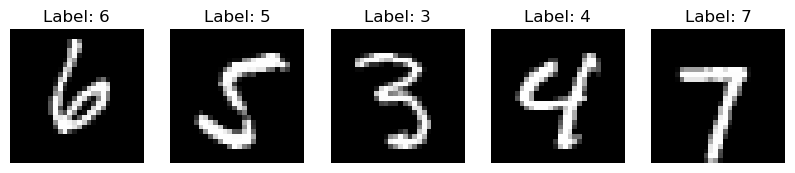

In [10]:
# Affichage d'exemples du dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()

In [11]:
# Encodage one-hot des labels
class CustomOneHotEncoder:
    def __init__(self, n_classes=10):
        self.n_classes = n_classes  # Nombre de classes
        self.encoder = OneHotEncoder(sparse_output=False)  # Crée un encodeur one-hot sans sortie sparse     
    def fit(self, y):
        # Entraîne l'encodeur sur une plage de valeurs de 0 à n_classes-1
        self.encoder.fit(np.arange(self.n_classes).reshape(-1, 1))
        return self
        
    def transform(self, y):
        # Transforme les labels en vecteurs one-hot
        return self.encoder.transform(y.reshape(-1, 1))

In [12]:
# Classe NeuralNetwork
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialisation des poids et des biais pour les couches du réseau
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Poids de la couche d'entrée à la couche cachée
        self.b1 = np.zeros(hidden_size)  # Biais de la couche cachée
        self.W2 = np.random.randn(hidden_size, hidden_size) * 0.01  # Poids de la première couche cachée à la deuxième
        self.b2 = np.zeros(hidden_size)  # Biais de la deuxième couche cachée
        self.W3 = np.random.randn(hidden_size, output_size) * 0.01  # Poids de la deuxième couche cachée à la couche de sortie
        self.b3 = np.zeros(output_size)  # Biais de la couche de sortie

    def relu(self, x):
        # Fonction d'activation ReLU (Rectified Linear Unit)
        return np.maximum(0, x)

    def softmax(self, x):
        # Fonction d'activation Softmax pour la couche de sortie
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Soustraire le max pour éviter l'explosion exponentielle
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # Normalisation pour obtenir des probabilités

    def forward(self, X):
        # Propagation avant à travers le réseau
        self.z1 = np.dot(X, self.W1) + self.b1  # Calcul de la sortie de la première couche
        self.a1 = self.relu(self.z1)  # Application de la fonction d'activation ReLU
        self.z2 = np.dot(self.a1, self.W2) + self.b2  # Calcul de la sortie de la deuxième couche
        self.a2 = self.relu(self.z2)  # Application de la fonction d'activation ReLU
        self.z3 = np.dot(self.a2, self.W3) + self.b3  # Calcul de la sortie de la couche de sortie
        self.a3 = self.softmax(self.z3)  # Application de la fonction d'activation Softmax
        return self.a3  # Retourne la sortie finale du réseau

    def compute_loss(self, y_pred, y_true):
        # Calcul de la perte (loss) en utilisant la log-vraisemblance négative
        m = y_true.shape[0]  # Nombre d'exemples
        log_likelihood = -np.log(np.clip(y_pred[range(m), y_true], 1e-10, 1.0))  # Log-vraisemblance négative
        return np.sum(log_likelihood) / m  # Retourne la perte moyenne

    def backward(self, X, y_true, encoder):
        # Rétropropagation pour calculer les gradients
        m = X.shape[0]  # Nombre d'exemples
        y_true_one_hot = encoder.transform(y_true)  # Conversion des labels en one-hot encoding

        # Calcul des gradients pour la couche de sortie
        dZ3 = self.a3 - y_true_one_hot  # Différence entre la prédiction et la vérité terrain
        dW3 = np.dot(self.a2.T, dZ3) / m  # Gradient des poids de la couche de sortie
        db3 = np.sum(dZ3, axis=0) / m  # Gradient des biais de la couche de sortie

        # Calcul des gradients pour la deuxième couche cachée
        dA2 = np.dot(dZ3, self.W3.T)  # Gradient de l'activation de la deuxième couche
        dZ2 = dA2 * (self.a2 > 0)  # Gradient de la sortie de la deuxième couche (avec ReLU)
        dW2 = np.dot(self.a1.T, dZ2) / m  # Gradient des poids de la deuxième couche
        db2 = np.sum(dZ2, axis=0) / m  # Gradient des biais de la deuxième couche

        # Calcul des gradients pour la première couche cachée
        dA1 = np.dot(dZ2, self.W2.T)  # Gradient de l'activation de la première couche
        dZ1 = dA1 * (self.a1 > 0)  # Gradient de la sortie de la première couche (avec ReLU)
        dW1 = np.dot(X.T, dZ1) / m  # Gradient des poids de la première couche
        db1 = np.sum(dZ1, axis=0) / m  # Gradient des biais de la première couche

        return dW1, db1, dW2, db2, dW3, db3  # Retourne les gradients calculés

In [27]:
class Optimizer:
    def __init__(self, learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        # Initialisation des hyperparamètres de l'optimiseur
        self.learning_rate = learning_rate  # Taux d'apprentissage
        self.beta1 = beta1  # Paramètre pour le momentum (moyenne mobile des gradients)
        self.beta2 = beta2  # Paramètre pour RMSprop (moyenne mobile des carrés des gradients)
        self.epsilon = epsilon  # Petite valeur pour éviter la division par zéro
        self.reset()  # Réinitialisation des variables internes

    def reset(self):
        # Réinitialisation des variables pour le momentum et RMSprop
        self.momentum_W1 = 0  # Momentum pour les poids W1
        self.momentum_b1 = 0  # Momentum pour les biais b1
        self.momentum_W2 = 0  # Momentum pour les poids W2
        self.momentum_b2 = 0  # Momentum pour les biais b2
        self.momentum_W3 = 0  # Momentum pour les poids W3
        self.momentum_b3 = 0  # Momentum pour les biais b3
        self.v_W1 = 0  # RMSprop pour les poids W1
        self.v_b1 = 0  # RMSprop pour les biais b1
        self.v_W2 = 0  # RMSprop pour les poids W2
        self.v_b2 = 0  # RMSprop pour les biais b2
        self.v_W3 = 0  # RMSprop pour les poids W3
        self.v_b3 = 0  # RMSprop pour les biais b3

    def sgd(self, model, dW1, db1, dW2, db2, dW3, db3):
        # Descente de gradient stochastique (SGD)
        model.W1 -= self.learning_rate * dW1  # Mise à jour des poids W1
        model.b1 -= self.learning_rate * db1  # Mise à jour des biais b1
        model.W2 -= self.learning_rate * dW2  # Mise à jour des poids W2
        model.b2 -= self.learning_rate * db2  # Mise à jour des biais b2
        model.W3 -= self.learning_rate * dW3  # Mise à jour des poids W3
        model.b3 -= self.learning_rate * db3  # Mise à jour des biais b3

    def momentum(self, model, dW1, db1, dW2, db2, dW3, db3):
        # Descente de gradient avec momentum
        self.momentum_W1 = self.beta1 * self.momentum_W1 + (1 - self.beta1) * dW1  # Mise à jour du momentum pour W1
        self.momentum_b1 = self.beta1 * self.momentum_b1 + (1 - self.beta1) * db1  # Mise à jour du momentum pour b1
        self.momentum_W2 = self.beta1 * self.momentum_W2 + (1 - self.beta1) * dW2  # Mise à jour du momentum pour W2
        self.momentum_b2 = self.beta1 * self.momentum_b2 + (1 - self.beta1) * db2  # Mise à jour du momentum pour b2
        self.momentum_W3 = self.beta1 * self.momentum_W3 + (1 - self.beta1) * dW3  # Mise à jour du momentum pour W3
        self.momentum_b3 = self.beta1 * self.momentum_b3 + (1 - self.beta1) * db3  # Mise à jour du momentum pour b3

        # Mise à jour des poids et biais en utilisant le momentum
        model.W1 -= self.learning_rate * self.momentum_W1
        model.b1 -= self.learning_rate * self.momentum_b1
        model.W2 -= self.learning_rate * self.momentum_W2
        model.b2 -= self.learning_rate * self.momentum_b2
        model.W3 -= self.learning_rate * self.momentum_W3
        model.b3 -= self.learning_rate * self.momentum_b3

    def nesterov_momentum(self, model, dW1, db1, dW2, db2, dW3, db3):
        # Momentum de Nesterov (variante améliorée du momentum)
        v_prev_W1, v_prev_b1 = self.momentum_W1, self.momentum_b1  # Sauvegarde des valeurs précédentes
        v_prev_W2, v_prev_b2 = self.momentum_W2, self.momentum_b2
        v_prev_W3, v_prev_b3 = self.momentum_W3, self.momentum_b3

        # Mise à jour du momentum
        self.momentum_W1 = self.beta1 * self.momentum_W1 + (1 - self.beta1) * dW1
        self.momentum_b1 = self.beta1 * self.momentum_b1 + (1 - self.beta1) * db1
        self.momentum_W2 = self.beta1 * self.momentum_W2 + (1 - self.beta1) * dW2
        self.momentum_b2 = self.beta1 * self.momentum_b2 + (1 - self.beta1) * db2
        self.momentum_W3 = self.beta1 * self.momentum_W3 + (1 - self.beta1) * dW3
        self.momentum_b3 = self.beta1 * self.momentum_b3 + (1 - self.beta1) * db3

        # Mise à jour des poids et biais en utilisant le momentum de Nesterov
        model.W1 -= self.learning_rate * (self.beta1 * v_prev_W1 + (1 - self.beta1) * dW1)
        model.b1 -= self.learning_rate * (self.beta1 * v_prev_b1 + (1 - self.beta1) * db1)
        model.W2 -= self.learning_rate * (self.beta1 * v_prev_W2 + (1 - self.beta1) * dW2)
        model.b2 -= self.learning_rate * (self.beta1 * v_prev_b2 + (1 - self.beta1) * db2)
        model.W3 -= self.learning_rate * (self.beta1 * v_prev_W3 + (1 - self.beta1) * dW3)
        model.b3 -= self.learning_rate * (self.beta1 * v_prev_b3 + (1 - self.beta1) * db3)

    def rmsprop(self, model, dW1, db1, dW2, db2, dW3, db3):
        # RMSprop (adaptation du taux d'apprentissage)
        self.v_W1 = self.beta2 * self.v_W1 + (1 - self.beta2) * (dW1 ** 2)  # Mise à jour de la moyenne mobile pour W1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (db1 ** 2)  # Mise à jour de la moyenne mobile pour b1
        self.v_W2 = self.beta2 * self.v_W2 + (1 - self.beta2) * (dW2 ** 2)  # Mise à jour de la moyenne mobile pour W2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (db2 ** 2)  # Mise à jour de la moyenne mobile pour b2
        self.v_W3 = self.beta2 * self.v_W3 + (1 - self.beta2) * (dW3 ** 2)  # Mise à jour de la moyenne mobile pour W3
        self.v_b3 = self.beta2 * self.v_b3 + (1 - self.beta2) * (db3 ** 2)  # Mise à jour de la moyenne mobile pour b3

        # Mise à jour des poids et biais en utilisant RMSprop
        model.W1 -= self.learning_rate * dW1 / (np.sqrt(self.v_W1) + self.epsilon)
        model.b1 -= self.learning_rate * db1 / (np.sqrt(self.v_b1) + self.epsilon)
        model.W2 -= self.learning_rate * dW2 / (np.sqrt(self.v_W2) + self.epsilon)
        model.b2 -= self.learning_rate * db2 / (np.sqrt(self.v_b2) + self.epsilon)
        model.W3 -= self.learning_rate * dW3 / (np.sqrt(self.v_W3) + self.epsilon)
        model.b3 -= self.learning_rate * db3 / (np.sqrt(self.v_b3) + self.epsilon)

    def newton(self, model, dW1, db1, dW2, db2, dW3, db3):
        # Méthode de Newton (simplifiée, en supposant une hessienne diagonale)
        model.W1 -= self.learning_rate * dW1 / (np.abs(dW1) + self.epsilon)  # Mise à jour des poids W1
        model.b1 -= self.learning_rate * db1 / (np.abs(db1) + self.epsilon)  # Mise à jour des biais b1
        model.W2 -= self.learning_rate * dW2 / (np.abs(dW2) + self.epsilon)  # Mise à jour des poids W2
        model.b2 -= self.learning_rate * db2 / (np.abs(db2) + self.epsilon)  # Mise à jour des biais b2
        model.W3 -= self.learning_rate * dW3 / (np.abs(dW3) + self.epsilon)  # Mise à jour des poids W3
        model.b3 -= self.learning_rate * db3 / (np.abs(db3) + self.epsilon)  # Mise à jour des biais b3

    def adam(self, model, dW1, db1, dW2, db2, dW3, db3, t):
        # Adam (combinaison de momentum et RMSprop)
        self.momentum_W1 = self.beta1 * self.momentum_W1 + (1 - self.beta1) * dW1  # Mise à jour du momentum pour W1
        self.momentum_b1 = self.beta1 * self.momentum_b1 + (1 - self.beta1) * db1  # Mise à jour du momentum pour b1
        self.momentum_W2 = self.beta1 * self.momentum_W2 + (1 - self.beta1) * dW2  # Mise à jour du momentum pour W2
        self.momentum_b2 = self.beta1 * self.momentum_b2 + (1 - self.beta1) * db2  # Mise à jour du momentum pour b2
        self.momentum_W3 = self.beta1 * self.momentum_W3 + (1 - self.beta1) * dW3  # Mise à jour du momentum pour W3
        self.momentum_b3 = self.beta1 * self.momentum_b3 + (1 - self.beta1) * db3  # Mise à jour du momentum pour b3

        self.v_W1 = self.beta2 * self.v_W1 + (1 - self.beta2) * (dW1 ** 2)  # Mise à jour de RMSprop pour W1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (db1 ** 2)  # Mise à jour de RMSprop pour b1
        self.v_W2 = self.beta2 * self.v_W2 + (1 - self.beta2) * (dW2 ** 2)  # Mise à jour de RMSprop pour W2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (db2 ** 2)  # Mise à jour de RMSprop pour b2
        self.v_W3 = self.beta2 * self.v_W3 + (1 - self.beta2) * (dW3 ** 2)  # Mise à jour de RMSprop pour W3
        self.v_b3 = self.beta2 * self.v_b3 + (1 - self.beta2) * (db3 ** 2)  # Mise à jour de RMSprop pour b3

        # Correction du biais pour le momentum et RMSprop
        m_W1_corr = self.momentum_W1 / (1 - self.beta1 ** t)
        m_b1_corr = self.momentum_b1 / (1 - self.beta1 ** t)
        m_W2_corr = self.momentum_W2 / (1 - self.beta1 ** t)
        m_b2_corr = self.momentum_b2 / (1 - self.beta1 ** t)
        m_W3_corr = self.momentum_W3 / (1 - self.beta1 ** t)
        m_b3_corr = self.momentum_b3 / (1 - self.beta1 ** t)

        v_W1_corr = self.v_W1 / (1 - self.beta2 ** t)
        v_b1_corr = self.v_b1 / (1 - self.beta2 ** t)
        v_W2_corr = self.v_W2 / (1 - self.beta2 ** t)
        v_b2_corr = self.v_b2 / (1 - self.beta2 ** t)
        v_W3_corr = self.v_W3 / (1 - self.beta2 ** t)
        v_b3_corr = self.v_b3 / (1 - self.beta2 ** t)

        # Mise à jour des poids et biais en utilisant Adam
        model.W1 -= self.learning_rate * m_W1_corr / (np.sqrt(v_W1_corr) + self.epsilon)
        model.b1 -= self.learning_rate * m_b1_corr / (np.sqrt(v_b1_corr) + self.epsilon)
        model.W2 -= self.learning_rate * m_W2_corr / (np.sqrt(v_W2_corr) + self.epsilon)
        model.b2 -= self.learning_rate * m_b2_corr / (np.sqrt(v_b2_corr) + self.epsilon)
        model.W3 -= self.learning_rate * m_W3_corr / (np.sqrt(v_W3_corr) + self.epsilon)
        model.b3 -= self.learning_rate * m_b3_corr / (np.sqrt(v_b3_corr) + self.epsilon)

In [28]:
def train(model, optimizer, opt_obj, X_train, y_train, X_test, y_test, encoder, epochs=10, batch_size=64):
    # Initialisation des variables pour stocker les pertes et les précisions
    n_samples = X_train.shape[0]  # Nombre total d'échantillons d'entraînement
    losses = []  # Pour stocker la perte moyenne par époque
    accuracies = []  # Pour stocker la précision sur l'ensemble de test par époque

    # Boucle sur les époques
    for epoch in range(epochs):
        start_time = time.time()  # Début du chronomètre pour mesurer le temps d'une époque
        epoch_loss = 0  # Initialisation de la perte pour l'époque actuelle

        # Mélange des données pour chaque époque
        permutation = np.random.permutation(n_samples)  # Permutation aléatoire des indices
        X_train_shuffled = X_train[permutation]  # Mélange des données d'entraînement
        y_train_shuffled = y_train[permutation]  # Mélange des labels d'entraînement

        # Boucle sur les lots (batches)
        for i in range(0, n_samples, batch_size):
            # Sélection du lot actuel
            X_batch = X_train_shuffled[i:i + batch_size]  # Données du lot
            y_batch = y_train_shuffled[i:i + batch_size]  # Labels du lot

            # Propagation avant : calcul des prédictions
            y_pred = model.forward(X_batch)
            # Calcul de la perte pour le lot actuel
            loss = model.compute_loss(y_pred, y_batch)
            epoch_loss += loss  # Ajout de la perte du lot à la perte totale de l'époque

            # Rétropropagation : calcul des gradients
            dW1, db1, dW2, db2, dW3, db3 = model.backward(X_batch, y_batch, encoder)

            # Mise à jour des paramètres du modèle en fonction de l'optimiseur choisi
            if optimizer == 'sgd':
                opt_obj.sgd(model, dW1, db1, dW2, db2, dW3, db3)  # Descente de gradient stochastique
            elif optimizer == 'momentum':
                opt_obj.momentum(model, dW1, db1, dW2, db2, dW3, db3)  # Momentum
            elif optimizer == 'nesterov':
                opt_obj.nesterov_momentum(model, dW1, db1, dW2, db2, dW3, db3)  # Momentum de Nesterov
            elif optimizer == 'rmsprop':
                opt_obj.rmsprop(model, dW1, db1, dW2, db2, dW3, db3)  # RMSprop
            elif optimizer == 'adam':
                opt_obj.adam(model, dW1, db1, dW2, db2, dW3, db3, 
                           epoch * (n_samples // batch_size) + i // batch_size + 1)  # Adam
            elif optimizer == 'newton':
                opt_obj.newton(model, dW1, db1, dW2, db2, dW3, db3)  # Méthode de Newton (simplifiée)

        # Évaluation du modèle sur l'ensemble de test
        y_pred_test = model.forward(X_test)  # Prédictions sur l'ensemble de test
        test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)  # Calcul de la précision
        losses.append(epoch_loss / (n_samples // batch_size))  # Stockage de la perte moyenne
        accuracies.append(test_accuracy)  # Stockage de la précision

        # Affichage des résultats pour l'époque actuelle
        logger.info(f"Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}, Accuracy: {test_accuracy:.4f}, Time: {time.time() - start_time:.2f}s")

    # Retour des pertes et des précisions pour chaque époque
    return losses, accuracies

In [29]:
# Chargement et préparation des données
X, y = load_data(file_path)  # Chargement des données depuis un fichier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Division des données en ensembles d'entraînement et de test (80% train, 20% test)

# Initialisation de l'encodeur
encoder = CustomOneHotEncoder(n_classes=10).fit(y)  # Création d'un encodeur one-hot pour les labels (10 classes)

# Initialisation de l'optimiseur
opt = Optimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)  # Création d'un optimiseur avec des hyperparamètres par défaut

# Entraînement avec différentes méthodes

# Entraînement avec SGD (Descente de Gradient Stochastique)
logger.info("Training with SGD")  # Log pour indiquer le début de l'entraînement avec SGD
model_sgd = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle de réseau de neurones
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_sgd, accuracies_sgd = train(model_sgd, 'sgd', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement du modèle avec SGD

# Entraînement avec Momentum
logger.info("Training with Momentum")  # Log pour indiquer le début de l'entraînement avec Momentum
model_momentum = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_momentum, accuracies_momentum = train(model_momentum, 'momentum', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement avec Momentum

# Entraînement avec Nesterov Momentum
logger.info("Training with Nesterov Momentum")  # Log pour indiquer le début de l'entraînement avec Nesterov Momentum
model_nesterov = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_nesterov, accuracies_nesterov = train(model_nesterov, 'nesterov', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement avec Nesterov Momentum

# Entraînement avec RMSProp
logger.info("Training with RMSProp")  # Log pour indiquer le début de l'entraînement avec RMSProp
model_rmsprop = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_rmsprop, accuracies_rmsprop = train(model_rmsprop, 'rmsprop', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement avec RMSProp

# Entraînement avec Adam
logger.info("Training with Adam")  # Log pour indiquer le début de l'entraînement avec Adam
model_adam = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_adam, accuracies_adam = train(model_adam, 'adam', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement avec Adam

# Entraînement avec Newton (Méthode de Newton simplifiée)
logger.info("Training with Newton")  # Log pour indiquer le début de l'entraînement avec Newton
model_newton = NeuralNetwork(input_size=784, hidden_size=100, output_size=10)  # Création d'un nouveau modèle
opt.reset()  # Réinitialisation des variables internes de l'optimiseur
losses_newton, accuracies_newton = train(model_newton, 'newton', opt, X_train, y_train, X_test, y_test, encoder, epochs=500, batch_size=128)  # Entraînement avec Newton

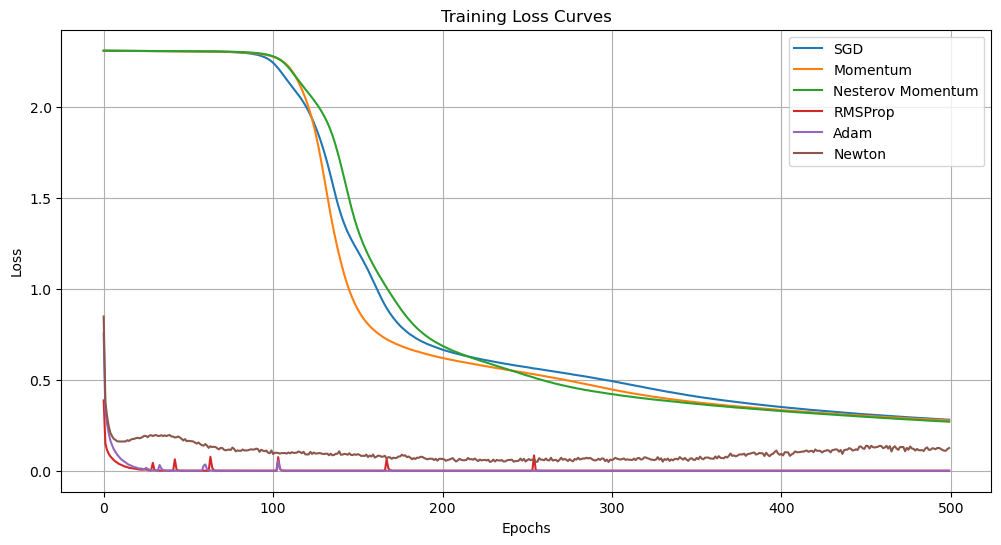

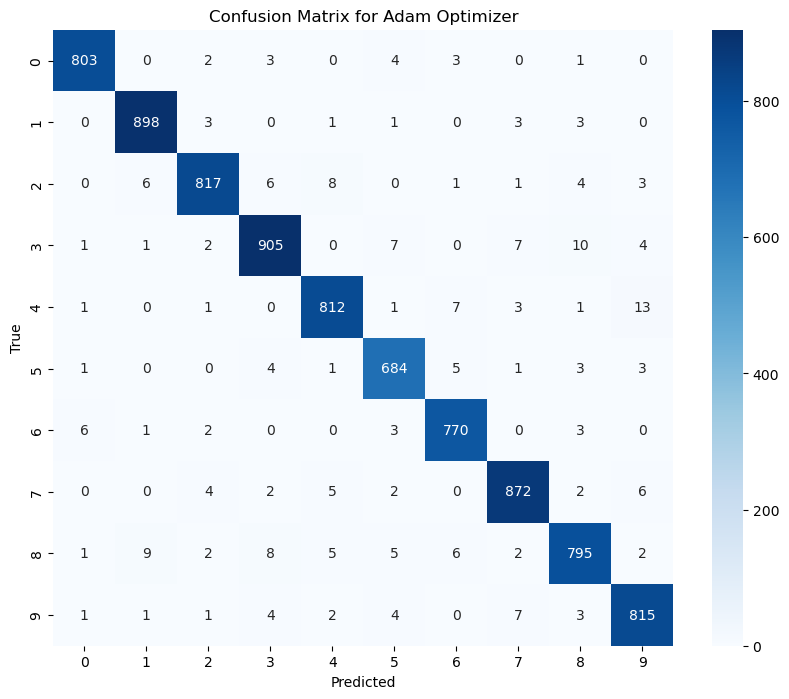

In [46]:
# Visualisation des courbes de perte
plt.figure(figsize=(12, 6))
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
plt.plot(losses_nesterov, label='Nesterov Momentum')
plt.plot(losses_rmsprop, label='RMSProp')
plt.plot(losses_adam, label='Adam')
plt.plot(losses_newton, label='Newton')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Matrice de confusion pour Adam (exemple)
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = model_adam.forward(X_test)
y_pred_labels = np.argmax(y_pred_test, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Adam Optimizer')
plt.savefig("Confusion Matrix for Adam Optimizer.png")  # Enregistrer l'image
plt.show()

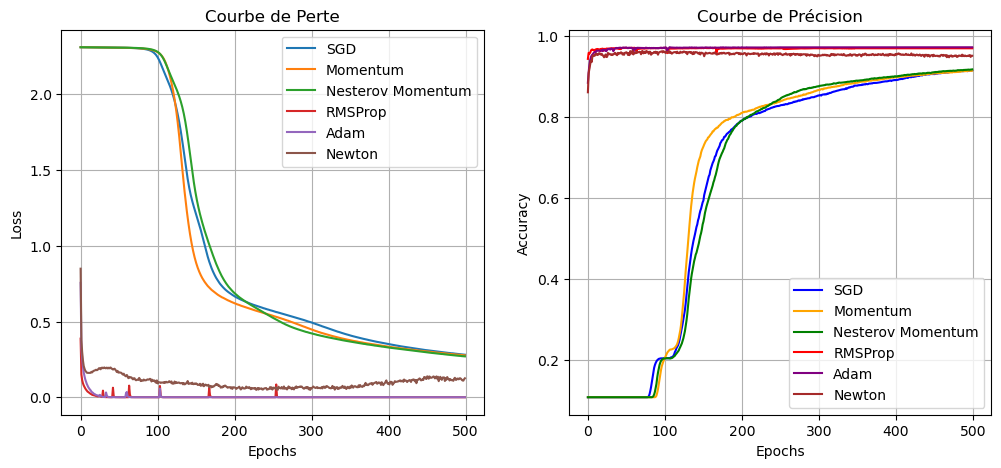

In [47]:
# Affichage des courbes de perte et précision
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_momentum, label='Momentum')
plt.plot(losses_nesterov, label='Nesterov Momentum')
plt.plot(losses_rmsprop, label='RMSProp')
plt.plot(losses_adam, label='Adam')
plt.plot(losses_newton, label='Newton')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Perte')
plt.legend()
plt.savefig("Courbe de Perte.png")  # Enregistrer l'image
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(accuracies_sgd, label='SGD', color='blue')
plt.plot(accuracies_momentum, label='Momentum', color='orange')
plt.plot(accuracies_nesterov, label='Nesterov Momentum', color='green')
plt.plot(accuracies_rmsprop, label='RMSProp', color='red')
plt.plot(accuracies_adam, label='Adam', color='purple')
plt.plot(accuracies_newton, label='Newton', color='brown')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig("Courbe de Précision.png")  # Enregistrer l'image
plt.title('Courbe de Précision')
plt.legend()
plt.grid()
plt.show()

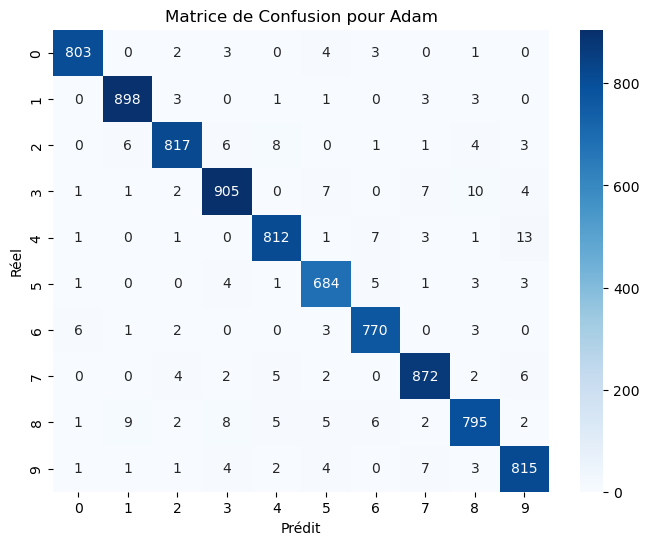

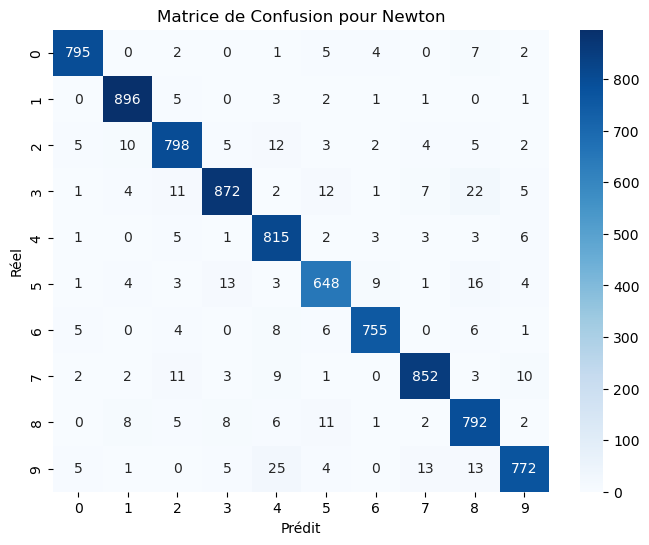

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matrice de confusion pour Adam 
y_pred_test = model_adam.forward(X_test)
y_pred_labels = np.argmax(y_pred_test, axis=1)
y_true_labels = y_test  

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion pour Adam')
plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matrice de confusion pour Newton
y_pred_test = model_newton.forward(X_test)
y_pred_labels = np.argmax(y_pred_test, axis=1)
y_true_labels = y_test  

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion pour Newton')
plt.show()

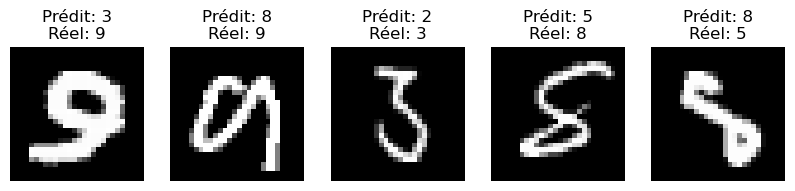

In [49]:
# Affichage d'exemples mal classifiés
misclassified_idx = np.where(y_pred_labels != y_true_labels)[0]
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test[misclassified_idx[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Prédit: {y_pred_labels[misclassified_idx[i]]}\nRéel: {y_true_labels[misclassified_idx[i]]}")
    ax.axis('off')
plt.savefig("Affichage d'exemples mal classifiés.png")  # Enregistrer l'image
plt.show()

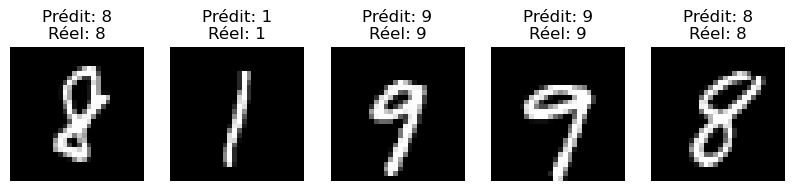

In [50]:
# Indices des exemples bien classifiés
correctly_classified_idx = np.where(y_pred_labels == y_true_labels)[0]

# Affichage des exemples bien classifiés
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_test[correctly_classified_idx[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Prédit: {y_pred_labels[correctly_classified_idx[i]]}\nRéel: {y_true_labels[correctly_classified_idx[i]]}")
    ax.axis('off')
plt.savefig("Affichage d'exemples bien classifiés.png")  # Enregistrer l'image
plt.show()